# Statistics on the output data. 

### Loading data from the sqlite database to the dataframes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random
from tabulate import tabulate

warnings.filterwarnings("ignore")


database = '../data/IoT.db'
# database = '../data/TinyVul.db'
# database = "/Users/guru/research/TinyVul.db"
conn= connect(database)

random.seed(0)

dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)

if not os.path.exists("figure"):
    os.mkdir("figure")
dfs.columns

Index(['file', 'line', 'column', 'defaultlevel', 'level', 'category', 'name',
       'msg', 'note', 'cwe', 'context', 'helpuri', 'severity', 'tool', 'type',
       'project'],
      dtype='object')

### Plotting subburset plot from the frequency of category, name and cwe types. 

In [4]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')
fig = px.sunburst(dfplt, 
    path=['category', 'name', 'cwe'], 
    values='count', 
    color_continuous_scale='Blues',
    color='count',
)
# fig.write_image("figure/vul_statistics.pdf")
# fig.update_traces(hovertemplate='%{label}<br>%{customdata}')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()
# save the figure manually, the below code takes ages
# fig.write_image("../figure/vul_statistics.pdf")

In [5]:
dfplt.sort_values(by=['count'], ascending=False).head(10)

,category,name,cwe,count
5,buffer,char,CWE-119!/CWE-120,65
11,fixed size global buffer,-,CWE-unknown,40
15,snprintf,-,CWE-unknown,37
9,buffer,strlen,CWE-126,28
14,memcpy,-,CWE-unknown,28
6,buffer,memcpy,CWE-120,28
17,strlen,-,CWE-unknown,24
10,buffer,strncpy,CWE-120,18
18,strncpy,-,CWE-unknown,18
7,buffer,sprintf,CWE-120,18


# Top 10 vulnerabilities

In [6]:
df_top10 = dfplt.sort_values(by=['count'], ascending=False).head(10).reset_index(drop=True)
print(tabulate(df_top10, headers='keys', tablefmt='psql'))
df_top10.to_latex("../result/top10.tex", index=False, caption="Top 10 CWEs in IoT code")

+----+--------------------------+---------+------------------+---------+
|    | category                 | name    | cwe              |   count |
|----+--------------------------+---------+------------------+---------|
|  0 | buffer                   | char    | CWE-119!/CWE-120 |      65 |
|  1 | fixed size global buffer | -       | CWE-unknown      |      40 |
|  2 | snprintf                 | -       | CWE-unknown      |      37 |
|  3 | buffer                   | strlen  | CWE-126          |      28 |
|  4 | memcpy                   | -       | CWE-unknown      |      28 |
|  5 | buffer                   | memcpy  | CWE-120          |      28 |
|  6 | strlen                   | -       | CWE-unknown      |      24 |
|  7 | buffer                   | strncpy | CWE-120          |      18 |
|  8 | strncpy                  | -       | CWE-unknown      |      18 |
|  9 | buffer                   | sprintf | CWE-120          |      18 |
+----+--------------------------+---------+--------

<AxesSubplot: >

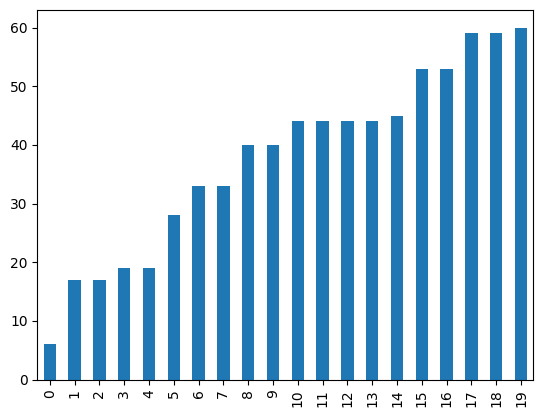

In [7]:
# dfs.context.head(200).str.len().plot(kind='bar')
pd.Series(sorted(list(dfs.context.head(20).str.len()))).plot(kind='bar')

In [8]:
dfs.context

0              char msg_ctxt_id[msgctxt_len + msgid_len];
1                                         char buf[1024];
2             memcpy (msg_ctxt_id, msgctxt, msgctxt_le...
3             memcpy (msg_ctxt_id + msgctxt_len, msgid...
4              char msg_ctxt_id[msgctxt_len + msgid_len];
                              ...                        
3369    unicast_open(&unicast, SHELL_RIME_CHANNEL_NETP...
3370    unicast_open(&unicast, SHELL_RIME_CHANNEL_NETP...
3371    unicast_open(&unicast, SHELL_RIME_CHANNEL_NETP...
3372    unicast_open(&unicast, SHELL_RIME_CHANNEL_NETP...
3373    unicast_open(&unicast, SHELL_RIME_CHANNEL_NETP...
Name: context, Length: 3374, dtype: object

<AxesSubplot: ylabel='Frequency'>

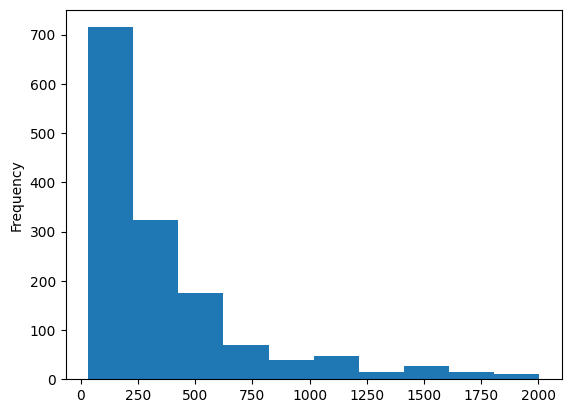

In [9]:
pd.Series([len(x) for x in dff.code if len(x)>10]).plot.hist(xlabel='#chars', ylabel='#statements')

In [10]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 

    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 79  #TODO: double check pep standards

# TODO: check min_len as well, otherwise the below code unnessesarily checks one extra condition 
# because there is no any statement/fun with len below that. 
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dff.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[17, 27, 33, 70, 18]

In [11]:
# df_dnn = pd.read_csv('../data/iDetect_refine/DNN_Binary.csv')
# df_conti = pd.read_csv('../data/contiki-master_Binary.csv')
# df_rasp = pd.read_csv('../data/raspberry_metrics.csv')
# df_rasp_flaw = pd.read_csv('../data/raspberry_flaw.csv')

# print('Shape of DNN data: ', df_dnn.shape)
# print('Shape of contiki: ', df_conti.shape)
# print('Shape of raspberry: ', df_rasp.shape)
# print('Shape of raspberry flaws: ', df_rasp_flaw.shape)

# dfcon = dfcon.rename(columns={'context': 'code'})
# dfcon.to_csv('../data/contiki-master_Binary.csv', index=False)

# Convert hyperparameters list to latex table format

In [12]:
def hyperpara2latex(yaml_file):
    """
    load the yaml file and return a dictionary
    """
    config = {}
    cols = ['hyperparameter', 'value']
    
    ext = Path(yaml_file).suffix.replace('.', '') 
    
    with open(yaml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            print(type(config))
            df = pd.DataFrame([config['dnn']]).T.reset_index()
            print(df.to_latex(index=False, 
                    header=cols, 
                    #   column_format='|l|l|', 
                    label='Hyperparameter Settings', 
                    caption='Hyperparameter Settings'))
        except yaml.YAMLError as exc:
            print(exc)

config = hyperpara2latex('../config.yaml')

<class 'dict'>
\begin{table}
\centering
\caption{Hyperparameter Settings}
\label{Hyperparameter Settings}
\begin{tabular}{ll}
\toprule
hyperparameter &                           value \\
\midrule
        epochs &                              50 \\
  debug\_epochs &                               3 \\
         batch &                             128 \\
  input\_length &                             150 \\
     input\_dim &                             150 \\
    output\_dim &                              32 \\
            lr &                            1e-4 \\
      patience &                             100 \\
     optimizer &                            adam \\
        l2\_reg &                            1e-4 \\
       dropout &                             0.0 \\
 recur\_dropout &                             0.0 \\
        beta\_1 &                             0.9 \\
        beta\_2 &                           0.999 \\
       epsilon &                           1e-08 \\
         decay &

## Frequency of the vulnerabilities and benign samples at 
    - statement-level 
    - function-level

In [13]:
# for project-wise distribution
projects = list(dfs.project.unique())

for project in projects:
    print(project)
    df = dfs[dfs.project == project]
    print(df.shape)
    print(df.cwe.value_counts())
    print(df.category.value_counts())
    print('----------------------')

/Users/guru/research/projects/gnucobol-3.2/lib/
(360, 16)
Benign              345
CWE-119!/CWE-120      4
CWE-120               4
CWE-126               4
CWE-562               3
Name: cwe, dtype: int64
buffer    12
-          3
Name: category, dtype: int64
----------------------
data/projects/contiki-2.4/apps/shell/
(3014, 16)
Benign              2687
CWE-unknown          166
CWE-120               62
CWE-119!/CWE-120      61
CWE-126               24
CWE-134               13
CWE-788                1
Name: cwe, dtype: int64
buffer                      147
fixed size global buffer     40
snprintf                     37
memcpy                       28
strlen                       24
strncpy                      18
format                       13
Static Global Buffer         11
-                             8
sprintf                       1
Name: category, dtype: int64
----------------------


## Create a latex table from the statistics of projects

In [14]:
def save_latex(df, file):
    """
    save the dataframe as latex table
    """
    styler = df.style
    # styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
    styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
    res = styler.to_latex(convert_css=True, column_format='|l|l|r|')

    with open(file, 'w') as f:
        f.write(res)
    return res

# make class binary type benign/vulnerable
dfs_binary = dfs.copy()
dfs_binary.loc[dfs_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dfs_binary['project'] = dfs_binary.project.str.split('/').str[-1]

prj_stat = dfs_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_stat.groupby(['project', 'cwe']).sum()

res = tabulate(save_latex(prj_s, '../result/project_stat.tex'))
prj_s

count
project cwe              
        Benign       3032
        Vulnerable    342

In [15]:
prj_sflat = prj_s.reset_index()
prj_sflat = prj_sflat.pivot(index='project', columns='cwe', values='count')
prj_sflat.reset_index().to_latex('../result/project_stat_flat.tex', index=False)

In [16]:
# make class binary type benign/vulnerable
dff_binary = dff.copy()
dff_binary.loc[dff_binary.cwe!="Benign", 'cwe'] = "Vulnerable"

prj_ff = dff_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_ff.groupby(['cwe']).sum().sort_values(by='count', ascending=False).reset_index()
prj_f = prj_f[prj_f.cwe != 'Benign'].head(10)
print(prj_f.to_latex(index=False, caption='Top 10 CWEs', label='Top 10 CWEs'))

\begin{table}
\centering
\caption{Top 10 CWEs}
\label{Top 10 CWEs}
\begin{tabular}{lr}
\toprule
       cwe &  count \\
\midrule
Vulnerable &     63 \\
\bottomrule
\end{tabular}
\end{table}



In [17]:
prj_s = dfs.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_s.groupby(['cwe']).sum()
prj_s

,count
cwe,
Benign,3032
CWE-119!/CWE-120,65
CWE-120,66
CWE-126,28
CWE-134,13
CWE-562,3
CWE-788,1
CWE-unknown,166


# Show the description of the function-level data

In [18]:
df_describe = dff_binary.drop(
    labels=['top_nesting_level', 'fan_in', 'fan_out', 'general_fan_out', 'content', 'long_name', 'fun_name', 'full_parameters', 'code'],
    axis=1, 
    errors='ignore').describe().T

df_freq = df_describe.reset_index().rename(columns={'index': 'features'})
df_freq = df_freq.drop(labels=['count'], axis=1)
# The freq is the most common value’s frequency. The top is the most common value.

print(df_freq[~df_freq.features.isin(['file'])].to_latex(
    index=False, 
    column_format='rrrrr', 
    label='Function Statistics', 
    caption='Function Statistics')
    )

\begin{table}
\centering
\caption{Function Statistics}
\label{Function Statistics}
\begin{tabular}{rrrrr}
\toprule
features & unique &                                   top & freq \\
\midrule
 context &     39 &                                       & 1372 \\
     cwe &      2 &                                Benign & 1372 \\
 project &      2 & data/projects/contiki-2.4/apps/shell/ & 1375 \\
\bottomrule
\end{tabular}
\end{table}



In [19]:
dfs.cwe.value_counts()

Benign              3032
CWE-unknown          166
CWE-120               66
CWE-119!/CWE-120      65
CWE-126               28
CWE-134               13
CWE-562                3
CWE-788                1
Name: cwe, dtype: int64

In [20]:
dff.cwe.value_counts()

Benign         1372
CWE-unknown      63
Name: cwe, dtype: int64

In [21]:
print(f'Size of statements: {len(dfs.context)}')
print(f'Size of unique statements: {dfs.context.nunique()}')

print(f'\nSize of functions: {len(dff.code)}')
print(f'Size of unique functions: {dff.code.nunique()}')

Size of statements: 3374
Size of unique statements: 382

Size of functions: 1435
Size of unique functions: 146


In [22]:
dff.cwe.value_counts()

Benign         1372
CWE-unknown      63
Name: cwe, dtype: int64

In [29]:
dfs.context.str.strip()

0              char msg_ctxt_id[msgctxt_len + msgid_len];
1                                         char buf[1024];
2         memcpy (msg_ctxt_id, msgctxt, msgctxt_len - 1);
3       memcpy (msg_ctxt_id + msgctxt_len, msgid, msgi...
4              char msg_ctxt_id[msgctxt_len + msgid_len];
                              ...                        
3369    unicast_open(&unicast, SHELL_RIME_CHANNEL_NETP...
3370    unicast_open(&unicast, SHELL_RIME_CHANNEL_NETP...
3371    unicast_open(&unicast, SHELL_RIME_CHANNEL_NETP...
3372    unicast_open(&unicast, SHELL_RIME_CHANNEL_NETP...
3373    unicast_open(&unicast, SHELL_RIME_CHANNEL_NETP...
Name: context, Length: 3374, dtype: object